# Primerjava algoritmov s Facebook grafom

In [68]:
#import libraries
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer
import pandas as pd
import itertools

## Algoritem za Katzovo središčnost

In [69]:
def katz(G, max_num_of_steps, tolerance, alpha, beta, vector=None):
    '''Computes the Katz centrality for the nodes of the graph G.'''
    start = timer()
    A = nx.adjacency_matrix(G)
    diff = 1000
    k = 0
    ones = np.ones((A.shape[1], 1))
    if vector is None:
        vector = ones
    r = beta * vector
    while diff > tolerance and k < max_num_of_steps:
        # inner product of matrix A and vector r
        r, q = alpha*A.dot(r) + beta * ones, r
        diff = np.linalg.norm(q-r, ord=1)
        k += 1
    r = r/np.linalg.norm(r,ord = 2)
    print('process finished after {} iterations'.format(k))
    end = timer()
    # timing of the process
    print('time consumption: {} seconds'.format(end-start))
    return r

## Algoritem za Googlov PageRank

In [70]:
def Qmatrix(matrix):
    '''for given adjecency matrix of a network returns column stohastic matrix Q,
    some columns may still be zero'''
    sums = np.sum(matrix, axis=0)       #array of sums of columns in matrix
    return np.nan_to_num(matrix/sums)   #divide every column with it's sum, if sum is 0,  
                                        #returns zero column instead of nan

def dvector(matrix):
    '''for given adjecency matrix returns transposed vector d, where d[j] = 1 ; if #(outlinks of j) = 0 
    and d[j] = 0 ; otherwise'''
    Q = Qmatrix(matrix)             #compute matrix Q
    sums = np.sum(matrix, axis=0)   #array of sums of columns in matrix 
    d_bool = (sums == 0)            #booleninan array, True if the sum of a column is equal to 0, false otherwise
    d = d_bool*1                    #convert False to 0 and True to 1
    return d

def evector(n):
    '''returns vector v of ones in size of n''' # n = num of columns in matrix
    return np.ones((n,1))    

def Pmatrix(matrix):
    '''returns column stohastic matrix P without zero columns'''
    n = matrix.shape[1]
    Q = Qmatrix(matrix)
    e = evector(n)
    d = dvector(matrix)
    return Q + 1/n*e.dot(d)

def Amatrix(matrix, alpha):
    '''returns ireducible column stohastic matrix A of given matrix, 
    where 0 <= alpha <= 1'''
    n = matrix.shape[1]
    e = evector(n)
    P = Pmatrix(matrix)
    return alpha*P + (1-alpha)*1/n*e.dot(e.transpose())

def pagerank2(matrix, max_num_of_steps, tolerance, alpha):
    '''returns pagerank vector of adjacency matrix, 0<=alpha<=1'''
    start = timer()
    A = Amatrix(matrix, alpha)           #column stohastic matrix from given matrix
    r = A[:,0]  #first guess for vector r is first column of Q
    diff = 1000
    k = 0
    while diff > tolerance and k < max_num_of_steps:
        r, q = A.dot(r), r              #inner product of matrix Q and vector r
        #r = q/np.linalg.norm(q, ord=1)  #not necessary
        diff = np.linalg.norm(q-r, ord=1)
        k+=1
    print('process finished after {} iterations'.format(k))
    end = timer()
    print('time consumption: {} seconds'.format(end-start))  #timing of the process
    return r

## Funkcija za primerjavo

In [71]:
def rank(array):
    '''Returns vector with ranked values of array,
    where 0 is the minimum value of array'''
    temp = array.argsort(axis=0)
    ranks = temp.argsort(axis=0)
    return ranks

## Graf FACEBOOK

In [72]:
#citation:@misc{snapnets,
#  author       = {Jure Leskovec and Andrej Krevl},
#  title        = {{SNAP Datasets}: {Stanford} Large Network Dataset Collection},
#  howpublished = {\url{http://snap.stanford.edu/data}},
#  month        = jun,
#  year         = 2014
#}
G_fb = nx.read_edgelist('facebook_combined.txt')

In [73]:
M_fb = nx.adjacency_matrix(G_fb)

In [74]:
print(nx.info(G_fb))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


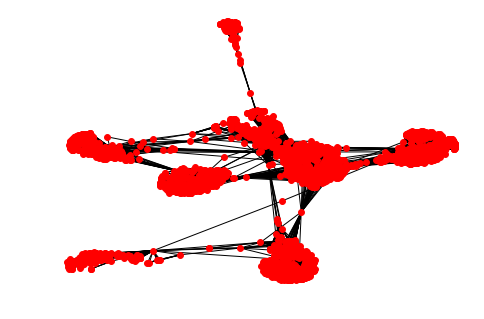

In [12]:
spring_pos = nx.spring_layout(G_fb)
nx.draw(G_fb, pos = spring_pos, node_size = 35)
plt.show()

In [32]:
#max lastna vrednost
print(np.amax(np.linalg.eigvals(M_fb.todense())))
print(1/162.37394233563828)

(162.37394233563828+0j)
0.006158623641304035


## Najini algoritmi

In [91]:
fb_katz = katz(G_fb, 100000, 0.000001, 0.003, 1)
fb_katz

process finished after 27 iterations
time consumption: 0.44329061200005526 seconds


array([[0.0270888 ],
       [0.01358663],
       [0.01327439],
       ...,
       [0.01291165],
       [0.01299224],
       [0.01318995]])

In [103]:
fb_pagerank = pagerank2(M_fb, 100000, 0.0000001, 0.85)
fb_pagerank

process finished after 89 iterations
time consumption: 4.48905998500004 seconds


matrix([[0.00622471],
        [0.0002358 ],
        [0.00019933],
        ...,
        [0.00010579],
        [0.00014798],
        [0.00029451]])

In [104]:
rank(fb_katz) == rank(fb_pagerank)

matrix([[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]])

Poglejmo v koliko vozliščih se algoritma ujemata.

In [105]:
np.sum(rank(fb_katz) == rank(fb_pagerank))

3

## Vgrajeni algoritmi vs. najini

### Katz

Če želimo enak rezultat kot pri vgrajenem algoritmu moramo pri obeh povečati toleranco na 0.000001.

In [90]:
fb_katz_vgrajen = nx.katz_centrality(G_fb, tol = 0.000001, alpha = 0.003, beta = 1)
fb_katz_vgrajen

{'0': 0.027088823813657556,
 '1': 0.013586635285779119,
 '2': 0.01327440179398391,
 '3': 0.013613601737325095,
 '4': 0.013265412278614991,
 '5': 0.013412095686215972,
 '6': 0.01310559420070561,
 '7': 0.013720745695810324,
 '8': 0.013183519072398496,
 '9': 0.015341681303343032,
 '10': 0.013314213746235821,
 '11': 0.012908536171379043,
 '12': 0.012908536171379043,
 '13': 0.014242324758098819,
 '14': 0.013477246288288086,
 '15': 0.012908536171379043,
 '16': 0.013250375953319344,
 '17': 0.013397086799252554,
 '18': 0.012908536171379043,
 '19': 0.013509688294100914,
 '20': 0.013474951597939636,
 '21': 0.01569852416303605,
 '22': 0.013326272856246232,
 '23': 0.013542082482040065,
 '24': 0.01352708302876298,
 '25': 0.015821767953773002,
 '26': 0.01582695354447199,
 '27': 0.013079128705010363,
 '28': 0.013395559403901662,
 '29': 0.013417936558442062,
 '30': 0.01361198886732957,
 '31': 0.013862510772810914,
 '32': 0.013107935263039541,
 '33': 0.012947378306295625,
 '34': 0.01313230677551214,
 '

In [92]:
katz_array_vgrajen = []

for k, v in fb_katz_vgrajen.items():
    katz_array_vgrajen.append(v)
katz_array_vgrajen = np.matrix(katz_array_vgrajen).transpose()
katz_array_vgrajen

matrix([[0.02708882],
        [0.01358664],
        [0.0132744 ],
        ...,
        [0.01291166],
        [0.01299225],
        [0.01318995]])

In [93]:
rank(fb_katz) == rank(katz_array_vgrajen)

matrix([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]])

In [94]:
np.sum(rank(fb_katz) == rank(katz_array_vgrajen)), 4039

(4039, 4039)

Naš Katz algoritem deluje! JUHU :)

### PageRank

Pri 0.00000000001 je 3950 True, pri 0.0000000000001 pa 3964. Ko je toleranca pri našem 0.0000001 pri vgrajenem pa 0.00000000001 dobimo 3954. :O. S tem se bomo zadovoljili.

In [102]:
fb_pagerank_vgrajen = nx.pagerank(G_fb, tol = 0.00000000001, alpha = 0.85, max_iter = 100000)
fb_pagerank_vgrajen

{'0': 0.006224696641265607,
 '1': 0.00023579432688654664,
 '2': 0.00019932730889815842,
 '3': 0.00022647422847718436,
 '4': 0.00023287052813355822,
 '5': 0.00020228946295229586,
 '6': 0.00017538836357811343,
 '7': 0.0002631932057024351,
 '8': 0.00023065358256195827,
 '9': 0.0006044414979279157,
 '10': 0.0001356107090297265,
 '11': 5.238572222373845e-05,
 '12': 5.238572222373845e-05,
 '13': 0.00033318424413721445,
 '14': 0.0002827529590921234,
 '15': 5.238572222373845e-05,
 '16': 0.00013363042120741636,
 '17': 0.0002546752546155784,
 '18': 5.238572222373845e-05,
 '19': 0.0003723985799504727,
 '20': 0.00028717564249491624,
 '21': 0.0006964931524006239,
 '22': 0.00016404935015571238,
 '23': 0.0003971231028646155,
 '24': 0.00022724714244609973,
 '25': 0.0008039547534844495,
 '26': 0.0006978641899496702,
 '27': 9.881222865947229e-05,
 '28': 0.00025015363791702793,
 '29': 0.00019209008521207442,
 '30': 0.00021302922179989393,
 '31': 0.0002998622298579961,
 '32': 0.00014558852213595084,
 '33'

In [106]:
pagerank_array_vgrajen = []

for k, v in fb_pagerank_vgrajen.items():
    pagerank_array_vgrajen.append(v)
pagerank_array_vgrajen = np.matrix(pagerank_array_vgrajen).transpose()
pagerank_array_vgrajen

matrix([[0.0062247 ],
        [0.00023579],
        [0.00019933],
        ...,
        [0.00010579],
        [0.00014798],
        [0.00029451]])

In [107]:
rank(fb_pagerank) == rank(pagerank_array_vgrajen)

matrix([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]])

In [108]:
np.sum(rank(fb_pagerank) == rank(pagerank_array_vgrajen)), 4039

(3954, 4039)

In [109]:
np.sum(rank(katz_array_vgrajen) == rank(pagerank_array_vgrajen)), 4039

(3, 4039)

In [110]:
np.sum(rank(fb_pagerank) == rank(fb_katz)), 4039

(3, 4039)

## Primerjava najinih algoritmov

In [179]:
katz_test = katz(G_fb, 100000, 0.000001, 0.0000001, 1)
katz_test = np.matrix(katz_test)
katz_test

process finished after 2 iterations
time consumption: 0.4004510150002716 seconds


matrix([[0.01573534],
        [0.01573482],
        [0.01573481],
        ...,
        [0.0157348 ],
        [0.0157348 ],
        [0.01573481]])

In [164]:
pagerank_test = pagerank2(M_fb, 100000, 0.0000001, 0.999)
pagerank_test

process finished after 4719 iterations
time consumption: 58.52657592199989 seconds


matrix([[2.37207123e-03],
        [1.15387662e-04],
        [6.99886732e-05],
        ...,
        [2.37766591e-05],
        [4.70770334e-05],
        [1.04002744e-04]])

In [180]:
np.sum(rank(katz_test) == rank(pagerank_test)), 4039

(10, 4039)

Največ sem prišla do 10 ujemanj, pri čemer je alpha pri Katzu zelo majhen...ne najbolje...

## ?????????????????